In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import tensorflow as tf
import numpy as np
import gym
from tqdm import tqdm, trange
import os, sys
sys.path.append(os.getcwd())

Populating the interactive namespace from numpy and matplotlib


In [2]:
class TicTacToe():
    def __init__(self, state=None):
        self.reset()
        if state is not None:
            self.state = state
        
    def reset(self):
        self.done = False
        self.state = [0]*11
        self.state[-1] = 1
        return self.state
    
    class observation_space():
        shape = (11,)

    class action_space():
        n = 9

    def render(self):
        # print(self.state)
        print(np.array(self.state[0:9]).reshape(3,3))
    
    def value(self, s):
        ret = 0
        for turn in [-1, 1]:
            for i in range(3):
                if all([x==turn for x in s[3*i:3*i+3]]):
                    ret = turn
                if all([x==turn for x in [s[i], s[3+i], s[6+i]]]):
                    ret = turn
                if all([x==turn for x in [s[0], s[4], s[8]]]):
                    ret = turn
                if all([x==turn for x in [s[2], s[4], s[6]]]):
                    ret = turn
        # NOTE: this is not the value, the state may be won
        return ret*s[-1]

    def dynamics(self, s, act):
        rew = 0
        s = s.copy()
        if s[act] != 0 or s[-2] != 0:
          # don't move in taken spots or in finished games
          rew = -10
        else:
            s[act] = s[-1]
            rew += self.value(s)
        if s[-2] != 0:
            rew = 0
        else:
            s[-2] = self.value(s)
        s[-1] = -s[-1]
        return rew, s

    def step(self, act):
        rew, self.state = self.dynamics(self.state, act)
        if rew != 0:
            self.done = True
        if np.all(np.array(self.state[0:9]) != 0):
            self.done = True
        return self.state, rew, self.done, None

In [3]:
env = TicTacToe()

In [4]:
env.render()

[[0 0 0]
 [0 0 0]
 [0 0 0]]


In [5]:
from muzero.model import MuModel
m = MuModel(env.observation_space.shape, env.action_space.n, s_dim=64, K=5, lr=0.001)
print(env.observation_space.shape, env.action_space.n)

from muzero.game import Game, ReplayBuffer
from muzero.mcts import naive_search, mcts_search
replay_buffer = ReplayBuffer(50, 128, m.K)
rews = []

(11,) 9


In [6]:
def play_game(env, m):
    import random
    game = Game(env, discount=0.99)
    while not game.terminal():
    # TODO: Do we need to limit the depth of the MCTS search?
    #policy = naive_search(m, game.observation, T=1)
        policy, _ = mcts_search(m, game.observation, 30)
        game.act_with_policy(policy)
    return game

In [7]:
from muzero.model import reformat_batch
import collections

for j in range(30):
    game = play_game(env, m)
    replay_buffer.save_game(game)
    for i in range(20):
        m.train_on_batch(replay_buffer.sample_batch())
    rew = sum(game.rewards)
    rews.append(rew)
    print(len(game.history), rew, game.history, m.losses[-1][0])

4 -10 [6, 3, 2, 3] 23.26535415649414
3 -10 [8, 2, 8] 25.777334213256836
3 -10 [8, 2, 2] 2974.60546875
2 -10 [2, 2] 70.80996704101562
3 -10 [8, 2, 2] 23047.78125
3 -10 [8, 2, 2] 134.8306427001953
3 -10 [8, 2, 2] 75.52555084228516
3 -10 [8, 2, 2] 66.74053192138672
2 -10 [2, 2] 56.41873550415039
2 -10 [2, 2] 46.13572311401367
2 -10 [2, 2] 31.300596237182617
2 -10 [2, 2] 22.62919807434082
2 -10 [2, 2] 18.126192092895508
2 -10 [2, 2] 11.45685863494873
2 -10 [2, 2] 9.366260528564453
3 -10 [8, 2, 2] 21.920124053955078
2 -10 [2, 2] 145.9978790283203
2 -10 [2, 2] 106.48115539550781
2 -10 [2, 2] 57.680030822753906
2 -10 [2, 2] 48.299560546875
2 -10 [2, 2] 54.41419219970703
2 -10 [2, 2] 131.357421875
2 -10 [2, 2] 398.8502197265625
3 -10 [5, 2, 2] 124.15632629394531
3 -10 [1, 2, 2] 147.28268432617188
3 -10 [8, 4, 4] 111.48078918457031
2 -10 [2, 2] 172.60926818847656
4 -10 [3, 2, 1, 2] 118.068115234375
4 -10 [5, 2, 6, 2] 123.5506362915039
5 -10 [1, 2, 6, 7, 6] 220.393310546875


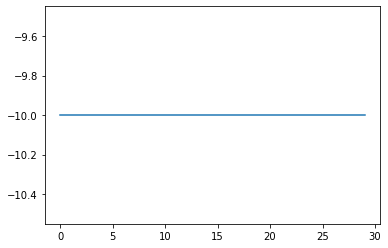

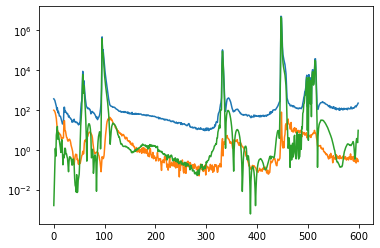

In [8]:
plot(rews)
figure()
plt.yscale('log')
plot([x[0] for x in m.losses])
plot([x[1] for x in m.losses])
plot([x[-3] for x in m.losses])